In [111]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import sys
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
def fix_timestamp(df):
                # Fix timestamp corruption (seconds sometimes interpreted as milliseconds)
                for col in df.columns:
                    if any(x in col.lower() for x in ["timestamp", "trade", "created_at", "end_date"]):
                        if pd.api.types.is_datetime64_any_dtype(df[col]):
                            if not df[col].empty and df[col].max() < pd.Timestamp("2020-01-01"):
                                logging.info(f"  Fixing corrupted timestamps in column: {col}")
                                # Scale up by 1000 to correct seconds-as-ms bug.
                                # Use astype('datetime64[ns]') to ensure we are working with nanoseconds
                                # before scaling, then convert back.
                                ns_values = df[col].values.astype("datetime64[ns]").astype("int64")
                                df[col] = pd.to_datetime(ns_values * 1000)
                                
                            # Enforce 2020+ constraint (replace placeholders/zeros with NaT)
                            if not df[col].empty:
                                mask = df[col] < pd.Timestamp("2020-01-01")
                                if mask.any():
                                    df.loc[mask, col] = pd.NaT    

In [5]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


# Plotting ACF and PACF of the closing value time series
#plot_acf_pacf(AMD_values['Close'])
# Function to plot ACF and PACF
def plot_acf_pacf(timeseries):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))
    plot_acf(timeseries, ax=ax1, lags=75)
    plot_pacf(timeseries, ax=ax2, lags=75)
    plt.show()

This code is a copy from Trilemmas code. We need to import this instead of copy/paste.

In [9]:
import logging
import sys
from pathlib import Path

# =============================================================================
# Constants
# =============================================================================

PRICE_COL = "PriceUSD_coinmetrics"
MVRV_COL = "CapMVRVCur"

# Strategy parameters
MIN_W = 1e-6
MA_WINDOW = 200  # 200-day simple moving average
MVRV_GRADIENT_WINDOW = 30  # Window for MVRV trend detection
MVRV_ROLLING_WINDOW = 365  # Window for MVRV Z-score normalization
MVRV_ACCEL_WINDOW = 14  # Window for acceleration calculation
DYNAMIC_STRENGTH = 5.0  # Multiplier for weight adjustments

# MVRV Zone thresholds (based on historical distribution)
MVRV_ZONE_DEEP_VALUE = -2.0  # Z-score threshold for deep value
MVRV_ZONE_VALUE = -1.0  # Z-score threshold for value
MVRV_ZONE_CAUTION = 1.5  # Z-score threshold for caution
MVRV_ZONE_DANGER = 2.5  # Z-score threshold for danger

# Volatility adjustment parameters
MVRV_VOLATILITY_WINDOW = 90  # Window for volatility calculation
MVRV_VOLATILITY_DAMPENING = (
    0.2  # How much to dampen signals in high volatility (reduced)
)

# Feature column names (for compatibility)
FEATS = [
    "price_vs_ma",
    "mvrv_zscore",
    "mvrv_gradient",
    "mvrv_acceleration",
    "mvrv_zone",
    "mvrv_volatility",
    "signal_confidence",
    "polymarket_sentiment",
]



def load_data():
    """Load BTC data from CoinMetrics CSV.

    Loads from local file: data/Coin Metrics/coinmetrics_btc.csv
    """
    BACKTEST_START = "2018-01-01"
    BACKTEST_END = "2025-12-31"
    
    # Try project root relative to this file
    #base_dir = Path(__file__).parent.parent
    #local_path = base_dir / "data" / "Coin Metrics" / "coinmetrics_btc.csv"
    local_path = Path("C:/monu/georgiatech/practicum/trilemma/bitcoin/bitcoin-analytics-capstone-template/data2/coinmetrics_btc.csv")
    
    # Fallback to CWD relative (for back-compat)
    if not local_path.exists():
        local_path = Path("data/Coin Metrics/coinmetrics_btc.csv")

    if not local_path.exists():
        raise FileNotFoundError(
            f"CoinMetrics BTC data file not found at {local_path}. "
            "Please ensure the file exists in the data/Coin Metrics/ directory."
        )

    logging.info(f"Loading CoinMetrics BTC data from local file: {local_path}")
    df = pd.read_csv(local_path)

    # Set time as index
    df["time"] = pd.to_datetime(df["time"])
    df.set_index("time", inplace=True)
    df.index = df.index.normalize().tz_localize(None)

    # Remove duplicates and sort
    df = df.loc[~df.index.duplicated(keep="last")].sort_index()

    # Use PriceUSD column from CoinMetrics (complete 2025 data)
    if "PriceUSD" not in df.columns:
        raise ValueError("PriceUSD column not found in CoinMetrics data")

    # Rename PriceUSD to PriceUSD_coinmetrics for compatibility
    df["PriceUSD_coinmetrics"] = df["PriceUSD"]

    # Assert all dates from BACKTEST_START to the latest available date have BTC-USD prices
    latest_date = df.index.max()
    backtest_dates = df.index[
        (df.index >= pd.to_datetime(BACKTEST_START)) & (df.index <= latest_date)
    ]
    missing_prices = df.loc[backtest_dates, "PriceUSD_coinmetrics"].isnull()
    if missing_prices.any():
        first_missing = df.loc[backtest_dates, "PriceUSD_coinmetrics"][
            missing_prices
        ].index.min()
        logging.warning(
            f"Missing BTC-USD prices for {missing_prices.sum()} dates from {BACKTEST_START} to {latest_date.date()}. "
            f"First missing date: {first_missing.date()}"
        )

    logging.info(
        f"Loaded CoinMetrics data: {len(df)} rows, {df.index.min().date()} to {df.index.max().date()}"
    )
    return df

def precompute_features(df: pd.DataFrame) -> pd.DataFrame:
    """Compute MVRV and MA features for weight calculation.

    Features (all lagged 1 day to prevent look-ahead bias):
    - price_vs_ma: Normalized distance from 200-day MA, clipped to [-1, 1]
    - mvrv_zscore: MVRV Z-score (365-day window), clipped to [-4, 4]
    - mvrv_gradient: Smoothed MVRV trend direction in [-1, 1]
    - mvrv_acceleration: Second derivative of MVRV gradient (momentum)
    - mvrv_zone: Discrete zone classification [-2, -1, 0, 1, 2]
    - polymarket_sentiment: Normalized sentiment from BTC market activity [0, 1]

    Args:
        df: DataFrame with price and MVRV columns

    Returns:
        DataFrame with price and computed features
    """
    if PRICE_COL not in df.columns:
        raise KeyError(f"'{PRICE_COL}' not found. Available: {list(df.columns)}")

    # Filter to valid date range
    price = df[PRICE_COL].loc["2010-07-18":].copy()

    # 200-day MA and distance
    ma = price.rolling(MA_WINDOW, min_periods=MA_WINDOW // 2).mean()
    with np.errstate(divide="ignore", invalid="ignore"):
        price_vs_ma = ((price / ma) - 1).clip(-1, 1).fillna(0)

    # MVRV features
    if MVRV_COL in df.columns:
        mvrv = df[MVRV_COL].loc[price.index]

        # Core Z-score (365-day window)
        mvrv_z = zscore(mvrv, MVRV_ROLLING_WINDOW).clip(-4, 4)

        # Smoothed gradient using EMA
        gradient_raw = mvrv_z.diff(MVRV_GRADIENT_WINDOW)
        gradient_smooth = gradient_raw.ewm(
            span=MVRV_GRADIENT_WINDOW, adjust=False
        ).mean()
        mvrv_gradient = np.tanh(gradient_smooth * 2).fillna(0)

        # MVRV acceleration (second derivative - momentum detection)
        accel_raw = mvrv_gradient.diff(MVRV_ACCEL_WINDOW)
        mvrv_acceleration = accel_raw.ewm(span=MVRV_ACCEL_WINDOW, adjust=False).mean()
        mvrv_acceleration = np.tanh(mvrv_acceleration * 3).fillna(0)

        # Zone classification
        mvrv_zone = pd.Series(
            classify_mvrv_zone(mvrv_z.values),
            index=mvrv_z.index,
        )

        # MVRV volatility (for signal dampening in uncertain periods)
        mvrv_volatility = compute_mvrv_volatility(mvrv_z, MVRV_VOLATILITY_WINDOW)

        # Signal confidence (computed after lag, using lagged values)
        # Will be computed after lag is applied
        signal_confidence = pd.Series(0.5, index=price.index)
    else:
        mvrv_z = pd.Series(0.0, index=price.index)
        mvrv_gradient = pd.Series(0.0, index=price.index)
        mvrv_acceleration = pd.Series(0.0, index=price.index)
        mvrv_zone = pd.Series(0, index=price.index)
        mvrv_volatility = pd.Series(0.5, index=price.index)
        signal_confidence = pd.Series(0.5, index=price.index)

    # Load Polymarket sentiment (if available)
    try:
        polymarket_df = load_polymarket_btc_sentiment()
        if not polymarket_df.empty:
            # Merge with price index, fill missing dates with neutral (0.5)
            polymarket_sentiment = polymarket_df["polymarket_sentiment"].reindex(
                price.index, fill_value=0.5
            )
        else:
            polymarket_sentiment = pd.Series(0.5, index=price.index)
    except (ImportError, FileNotFoundError, Exception) as e:
        # If Polymarket data not available, use neutral sentiment
        logging.warning(f"Polymarket sentiment not available: {e}")
        polymarket_sentiment = pd.Series(0.5, index=price.index)

    # Build and lag features
    features = pd.DataFrame(
        {
            PRICE_COL: price,
            "price_ma": ma,
            "price_vs_ma": price_vs_ma,
            "mvrv_zscore": mvrv_z,
            "mvrv_gradient": mvrv_gradient,
            "mvrv_acceleration": mvrv_acceleration,
            "mvrv_zone": mvrv_zone,
            "mvrv_volatility": mvrv_volatility,
            "signal_confidence": signal_confidence,
            "polymarket_sentiment": polymarket_sentiment,
        },
        index=price.index,
    )

    # Lag signals by 1 day to prevent look-ahead bias
    signal_cols = [
        "price_vs_ma",
        "mvrv_zscore",
        "mvrv_gradient",
        "mvrv_acceleration",
        "mvrv_zone",
        "mvrv_volatility",
        "polymarket_sentiment",
    ]
    features[signal_cols] = features[signal_cols].shift(1)

    # Fill NaN values with appropriate defaults
    features["mvrv_zone"] = features["mvrv_zone"].fillna(0)
    features["mvrv_volatility"] = features["mvrv_volatility"].fillna(0.5)
    features["polymarket_sentiment"] = features["polymarket_sentiment"].fillna(0.5)
    features = features.fillna(0)

    # Compute signal confidence using lagged values (no look-ahead)
    features["signal_confidence"] = compute_signal_confidence(
        features["mvrv_zscore"].values,
        features["mvrv_gradient"].values,
        features["price_vs_ma"].values,
    )

    return features



def load_polymarket_data() -> dict[str, pd.DataFrame]:
    """Load all raw Polymarket data files.
    
    Returns:
        Dictionary mapping file names to DataFrames:
        - 'markets': finance_politics_markets.parquet
        - 'tokens': finance_politics_tokens.parquet
        - 'trades': finance_politics_trades.parquet
        - 'odds_history': finance_politics_odds_history.parquet
        - 'event_stats': finance_politics_event_stats.parquet
        - 'summary': finance_politics_summary.parquet
        
    Missing files will be logged as warnings and excluded from the returned dictionary.
    """
    from pathlib import Path
    #base_dir = Path(__file__).parent.parent
    #polymarket_dir = base_dir / "data" / "Polymarket"
    
    
    # Fallback to CWD relative
    #if not polymarket_dir.exists():
    #    polymarket_dir = Path("data/Polymarket")
    #polymarket_dir=Path('C:/monu/georgiatech/practicum/trilemma/bitcoin/bitcoin-analytics-capstone-template/data/Polymarket')
    polymarket_dir=Path('C:/monu/georgiatech/practicum/trilemma/bitcoin/bitcoin-analytics-capstone-template/data2')
    
    if not polymarket_dir.exists():
        logging.warning(
            f"Polymarket data directory not found at {polymarket_dir}. "
            "Returning empty dictionary."
        )
        return {}
    
    # Map of file keys to actual filenames
    file_map = {
        "markets": "finance_politics_markets.parquet",
        "tokens": "finance_politics_tokens.parquet",
        "trades": "finance_politics_trades.parquet",
        "odds_history": "finance_politics_odds_history.parquet",
        "event_stats": "finance_politics_event_stats.parquet",
        "summary": "finance_politics_summary.parquet",
    }
    
    data = {}
    for key, filename in file_map.items():
        file_path = polymarket_dir / filename
        if file_path.exists():
            try:
                logging.info(f"Loading Polymarket data: {filename}")
                df = pd.read_parquet(file_path)
                
                # Fix timestamp corruption (seconds sometimes interpreted as milliseconds)
                for col in df.columns:
                    if any(x in col.lower() for x in ["timestamp", "trade", "created_at", "end_date"]):
                        if pd.api.types.is_datetime64_any_dtype(df[col]):
                            if not df[col].empty and df[col].max() < pd.Timestamp("2020-01-01"):
                                logging.info(f"  Fixing corrupted timestamps in column: {col}")
                                # Scale up by 1000 to correct seconds-as-ms bug.
                                # Use astype('datetime64[ns]') to ensure we are working with nanoseconds
                                # before scaling, then convert back.
                                ns_values = df[col].values.astype("datetime64[ns]").astype("int64")
                                df[col] = pd.to_datetime(ns_values * 1000)
                                
                            # Enforce 2020+ constraint (replace placeholders/zeros with NaT)
                            if not df[col].empty:
                                mask = df[col] < pd.Timestamp("2020-01-01")
                                if mask.any():
                                    df.loc[mask, col] = pd.NaT
                                
                data[key] = df
                logging.info(f"  Loaded {len(df)} rows from {filename}")
            except Exception as e:
                logging.warning(f"Failed to load {filename}: {e}")
        else:
            logging.warning(f"Polymarket file not found: {file_path}")
    
    if data:
        logging.info(f"Successfully loaded {len(data)} Polymarket data file(s)")
    else:
        logging.warning("No Polymarket data files were loaded")
    
    return data

def zscore(series: pd.Series, window: int) -> pd.Series:
    """Compute rolling z-score."""
    mean = series.rolling(window, min_periods=window // 2).mean()
    std = series.rolling(window, min_periods=window // 2).std()
    return ((series - mean) / std).fillna(0)

def classify_mvrv_zone(mvrv_zscore: np.ndarray) -> np.ndarray:
    """Classify MVRV into discrete zones for regime detection.

    Zones:
    - -2 (deep_value): Z < -2.0 (historically rare, extreme buying opportunity)
    - -1 (value): -2.0 <= Z < -1.0 (undervalued, increase buying)
    -  0 (neutral): -1.0 <= Z < 1.5 (fair value, normal DCA)
    - +1 (caution): 1.5 <= Z < 2.5 (overvalued, reduce buying)
    - +2 (danger): Z >= 2.5 (extreme overvaluation, minimize buying)

    Args:
        mvrv_zscore: Array of MVRV Z-scores

    Returns:
        Array of zone classifications in [-2, -1, 0, 1, 2]
    """
    return np.select(
        [
            mvrv_zscore < MVRV_ZONE_DEEP_VALUE,
            mvrv_zscore < MVRV_ZONE_VALUE,
            mvrv_zscore < MVRV_ZONE_CAUTION,
            mvrv_zscore < MVRV_ZONE_DANGER,
        ],
        [-2, -1, 0, 1],
        default=2,
    )


def compute_mvrv_volatility(mvrv_zscore: pd.Series, window: int) -> pd.Series:
    """Compute rolling volatility of MVRV Z-score.

    High volatility periods suggest uncertainty - signals should be dampened.
    Low volatility periods suggest conviction - signals can be amplified.

    Args:
        mvrv_zscore: MVRV Z-score series
        window: Rolling window for volatility calculation

    Returns:
        Normalized volatility in [0, 1] where 1 = high volatility
    """
    vol = mvrv_zscore.rolling(window, min_periods=window // 4).std()
    # Normalize to [0, 1] using historical quantiles
    vol_pct = vol.rolling(window * 4, min_periods=window).apply(
        lambda x: (x.iloc[-1] > x[:-1]).sum() / max(len(x) - 1, 1)
        if len(x) > 1
        else 0.5,
        raw=False,
    )
    return vol_pct.fillna(0.5)


def compute_signal_confidence(
    mvrv_zscore: np.ndarray,
    mvrv_gradient: np.ndarray,
    price_vs_ma: np.ndarray,
) -> np.ndarray:
    """Compute confidence score based on signal agreement.

    When multiple signals agree, confidence is high:
    - Low Z-score + Rising gradient = High confidence buy
    - High Z-score + Falling gradient = High confidence reduce

    Args:
        mvrv_zscore: MVRV Z-score in [-4, 4]
        mvrv_gradient: Trend direction in [-1, 1]
        price_vs_ma: Price vs MA in [-1, 1]

    Returns:
        Confidence score in [0, 1] where 1 = all signals strongly agree
    """
    # Normalize all signals to [-1, 1] where negative = buy signal
    z_signal = -mvrv_zscore / 4  # Normalize to [-1, 1]
    ma_signal = -price_vs_ma  # Below MA = buy signal

    # Gradient indicates momentum direction
    # Positive gradient with buy signals = confirmation
    # Negative gradient with buy signals = divergence (lower confidence)
    gradient_alignment = np.where(
        z_signal < 0,  # Buy signal from Z-score
        np.where(mvrv_gradient > 0, 1.0, 0.5),  # Rising = confirmation
        np.where(mvrv_gradient < 0, 1.0, 0.5),  # Falling = confirmation for sell
    )

    # Calculate agreement: how many signals point the same direction?
    signals = np.stack([z_signal, ma_signal], axis=0)
    signal_std = signals.std(axis=0)

    # Low std = high agreement, high std = disagreement
    # Transform std to confidence: confidence = 1 - normalized_std
    max_std = 1.0  # Maximum possible std when signals fully disagree
    agreement = 1.0 - np.clip(signal_std / max_std, 0, 1)

    # Combine agreement with gradient alignment
    confidence = agreement * 0.7 + gradient_alignment * 0.3

    return np.clip(confidence, 0, 1)

def load_polymarket_btc_sentiment() -> pd.DataFrame:
    """Load Polymarket BTC-related markets and compute daily sentiment.
    
    This is a model-specific function that processes raw Polymarket data
    to extract BTC sentiment signals. It uses the general load_polymarket_data()
    function from template/prelude_template.py.
    
    Aggregates BTC-related prediction markets by creation date to compute:
    - daily_market_count: number of new BTC markets created each day
    - daily_volume: total volume of BTC markets created each day
    - polymarket_sentiment: normalized sentiment score [0, 1]
    
    Returns:
        DataFrame indexed by date with sentiment features.
        Returns empty DataFrame if Polymarket data not found.
    """
    # Load raw Polymarket data using the general function
    polymarket_data = load_polymarket_data()
    
    if "markets" not in polymarket_data:
        logging.warning(
            "Polymarket markets data not found. "
            "Polymarket sentiment will be neutral (0.0) for all dates."
        )
        return pd.DataFrame()
    
    markets_df = polymarket_data["markets"]
    
    # Filter to BTC-related markets
    btc_markets = markets_df[
        markets_df["question"].str.contains("Bitcoin|BTC|btc", case=False, na=False)
    ].copy()
    
    logging.info(f"Found {len(btc_markets)} BTC-related markets in Polymarket data")
    
    if btc_markets.empty:
        logging.warning("No BTC-related markets found in Polymarket data")
        return pd.DataFrame()
    
    # Extract creation date (normalize to date only)
    btc_markets["created_date"] = pd.to_datetime(btc_markets["created_at"]).dt.normalize()
    
    # Aggregate by creation date
    daily_stats = btc_markets.groupby("created_date").agg(
        daily_market_count=("market_id", "count"),
        daily_volume=("volume", "sum")
    ).reset_index()
    
    # Compute normalized sentiment score
    # High market creation activity = high sentiment
    # Use rolling 30-day percentile to normalize
    daily_stats = daily_stats.set_index("created_date").sort_index()
    
    # Compute rolling percentiles (30-day window)
    daily_stats["market_count_pct"] = (
        daily_stats["daily_market_count"]
        .rolling(30, min_periods=1)
        .apply(lambda x: (x.iloc[-1] > x[:-1]).sum() / max(len(x) - 1, 1) if len(x) > 1 else 0.5)
    )
    
    daily_stats["volume_pct"] = (
        daily_stats["daily_volume"]
        .rolling(30, min_periods=1)
        .apply(lambda x: (x.iloc[-1] > x[:-1]).sum() / max(len(x) - 1, 1) if len(x) > 1 else 0.5)
    )
    
    # Combine into single sentiment score (average of percentiles)
    daily_stats["polymarket_sentiment"] = (
        daily_stats["market_count_pct"] * 0.5 + daily_stats["volume_pct"] * 0.5
    )
    
    # Fill NaN with neutral (0.5)
    daily_stats["polymarket_sentiment"] = daily_stats["polymarket_sentiment"].fillna(0.5)
    
    logging.info(
        f"Polymarket sentiment computed: {len(daily_stats)} days, "
        f"{daily_stats.index.min().date()} to {daily_stats.index.max().date()}"
    )
    
    return daily_stats[["polymarket_sentiment"]]



In [44]:
#TODO : change DIR_NAME
DIR_NAME="C:/monu/georgiatech/practicum/trilemma/bitcoin/bitcoin-analytics-capstone-template/data2/"
df_btc = pd.read_csv(DIR_NAME + "coinmetrics_btc.csv")
df_btc["time"] = pd.to_datetime(df_btc["time"])
df_btc.set_index("time", inplace=True)
df_btc.index = df_btc.index.normalize().tz_localize(None)

# Remove duplicates and sort
df_btc = df_btc.loc[~df_btc.index.duplicated(keep="last")].sort_index()
#df_btc=df_btc.dropna()
df_btc.head()
#df_btc.columns

,AdrActCnt,AdrBalCnt,AssetCompletionTime,AssetEODCompletionTime,BlkCnt,CapMVRVCur,CapMrktCurUSD,CapMrktEstUSD,FeeTotNtv,FlowInExNtv,...,ReferenceRateETH,ReferenceRateEUR,ReferenceRateUSD,SplyCur,SplyExNtv,SplyExUSD,SplyExpFut10yr,TxCnt,TxTfrCnt,volume_reported_spot_usd_1d
time,,,,,,,,,,,,,,,,,,,,,
2009-01-03,0.0,0.0,1.614335e+09,1.614335e+09,0.0,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN
2009-01-04,0.0,0.0,1.614335e+09,1.614335e+09,0.0,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN
2009-01-05,0.0,0.0,1.614335e+09,1.614335e+09,0.0,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN
2009-01-06,0.0,0.0,1.614335e+09,1.614335e+09,0.0,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN
2009-01-07,0.0,0.0,1.614335e+09,1.614335e+09,0.0,NaN,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN


Describe the data.

In [52]:
df_btc.describe()

,AdrActCnt,AdrBalCnt,AssetCompletionTime,AssetEODCompletionTime,BlkCnt,CapMVRVCur,CapMrktCurUSD,CapMrktEstUSD,FeeTotNtv,FlowInExNtv,...,ReferenceRateETH,ReferenceRateEUR,ReferenceRateUSD,SplyCur,SplyExNtv,SplyExUSD,SplyExpFut10yr,TxCnt,TxTfrCnt,volume_reported_spot_usd_1d
count,6.220000e+03,6.220000e+03,6.220000e+03,6.220000e+03,6220.000000,5659.000000,5.659000e+03,2.398000e+03,6220.000000,6220.000000,...,7.000000,7.000000,7.000000,6.220000e+03,6.220000e+03,5.659000e+03,6.214000e+03,6220.000000,6.220000e+03,5.659000e+03
mean,5.009057e+05,2.080860e+07,1.636422e+09,1.636422e+09,149.868810,1.989795,3.826396e+11,8.633915e+11,48.228897,25838.964889,...,29.161564,78563.321591,91487.781788,1.419667e+07,9.479984e+05,4.012445e+10,1.979521e+07,208414.228457,4.971118e+05,5.116673e+09
std,3.794394e+05,1.958234e+07,4.220227e+07,4.220227e+07,30.743195,2.493876,5.873727e+11,6.398350e+11,91.173237,24373.197547,...,0.295175,1441.867173,1711.761816,5.794621e+06,8.181572e+05,7.342693e+10,1.037226e+06,170293.817001,3.733056e+05,7.584967e+09
min,0.000000e+00,0.000000e+00,1.614335e+09,1.614335e+09,0.000000,0.386829,1.776705e+05,9.058570e+10,0.000000,0.000000,...,28.686314,77790.505193,90406.142411,0.000000e+00,0.000000e+00,0.000000e+00,1.707025e+07,0.000000,0.000000e+00,0.000000e+00
25%,6.069600e+04,1.374226e+06,1.614336e+09,1.614336e+09,137.000000,1.294023,3.672256e+09,3.553683e+11,8.206849,9739.439215,...,28.988983,77950.803938,90628.404772,1.100396e+07,8.793724e+04,8.975455e+07,1.916582e+07,47152.500000,1.043238e+05,1.057649e+07
50%,5.968805e+05,1.830680e+07,1.614337e+09,1.614337e+09,150.000000,1.754254,9.793110e+10,6.989680e+11,19.542053,21445.549012,...,29.300019,78130.277588,91096.916155,1.643875e+07,8.140561e+05,7.592223e+09,2.019138e+07,224415.500000,5.578790e+05,1.349240e+09
75%,8.175268e+05,3.851661e+07,1.634030e+09,1.634030e+09,162.000000,2.256760,5.545583e+11,1.237536e+12,45.831708,34086.280950,...,29.340685,78152.300810,91175.053055,1.884127e+07,1.533906e+06,4.227143e+10,2.062572e+07,312607.500000,7.981745e+05,8.188261e+09
max,1.366494e+06,5.592428e+07,1.768360e+09,1.768360e+09,692.000000,146.038332,2.487865e+12,2.487527e+12,1495.748916,284367.709273,...,29.485280,81816.258857,95304.498294,1.997535e+07,2.805575e+06,3.345030e+11,2.082639e+07,928131.000000,2.041653e+06,7.478639e+10


Plot data

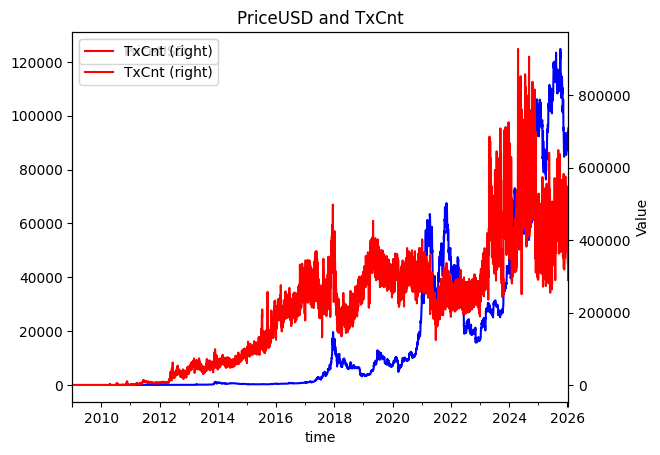

In [62]:
df2 = df_btc[['PriceUSD','CapMVRVCur','TxCnt']]
#df2.plot()

#plt.show()

ax = df2.plot(y='PriceUSD', label='PriceUSD', color='blue')
df2.plot(y='TxCnt', label='TxCnt', color='red', ax=ax, secondary_y=True)

#ax = df2.plot(y='CapMVRVCur', label='CapMVRVCur', color='blue')
#df2.plot(y='PriceUSD', label='PriceUSD', color='red', ax=ax, secondary_y=True)
#df2.plot(y='TxCnt', label='TxCnt', color='green', ax=ax, secondary_y=True)

#df.plot(y='profit', label='Profit', color='green', ax=ax)

plt.title('PriceUSD and TxCnt')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

#Plot in log scale

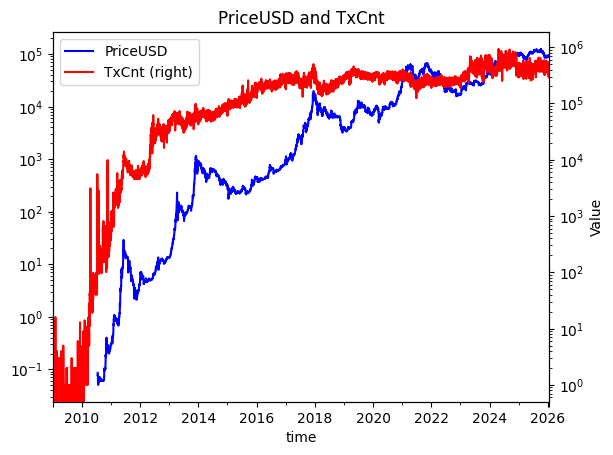

In [67]:
df2 = df_btc[['PriceUSD','CapMVRVCur','TxCnt']]
#df2.plot()

#plt.show()

ax = df2.plot(y='PriceUSD', label='PriceUSD', color='blue', logy=True)
df2.plot(y='TxCnt', label='TxCnt', color='red', ax=ax, secondary_y=True, logy=True)

#ax = df2.plot(y='CapMVRVCur', label='CapMVRVCur', color='blue')
#df2.plot(y='PriceUSD', label='PriceUSD', color='red', ax=ax, secondary_y=True)
#df2.plot(y='TxCnt', label='TxCnt', color='green', ax=ax, secondary_y=True)

#df.plot(y='profit', label='Profit', color='green', ax=ax)

plt.title('PriceUSD and TxCnt')
plt.xlabel('Index')
plt.ylabel('Value')
#plt.legend()
plt.show()

Do a seasonal decomposition and plot the data (Multiplicative)

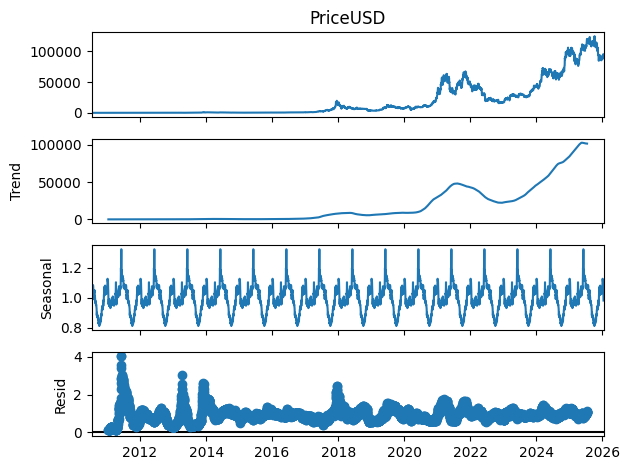

In [190]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


result = seasonal_decompose(df_btc['PriceUSD'].dropna(), model='multiplicative', period=365)  # Adjust period based on your data

# Extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Save the results in decomposition_results with the column name as the key
decomposition_results = {
    'Close': {
        'trend': trend,
        'seasonal': seasonal,
        'residual': residual
    }
}

# Plot the decomposition
result.plot()
plt.tight_layout()
plt.show()

Seasonality seems to be 2 years ???


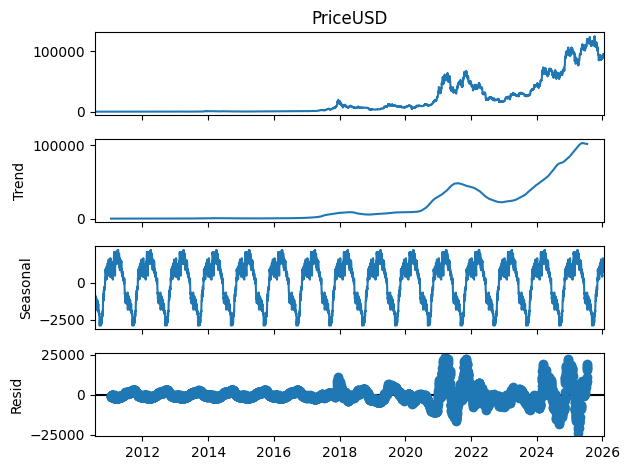

In [74]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


result = seasonal_decompose(df_btc['PriceUSD'].dropna(), model='additive', period=365)  # Adjust period based on your data

# Extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Save the results in decomposition_results with the column name as the key
decomposition_results = {
    'Close': {
        'trend': trend,
        'seasonal': seasonal,
        'residual': residual
    }
}

# Plot the decomposition
result.plot()
plt.tight_layout()
plt.show()

Based on the residuals looks like multiplicative seems to be better.

Plot of Moving averages of PriceUSD

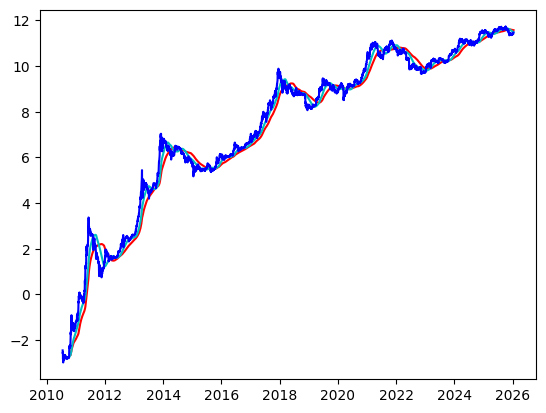

In [93]:
MA_WINDOW_200=200

ma_200 = df_btc['PriceUSD'].rolling(MA_WINDOW_200, min_periods=MA_WINDOW_200 // 2).mean()

MA_WINDOW_100=100
ma2 = df_btc['PriceUSD'].rolling(MA_WINDOW_100, min_periods=MA_WINDOW_100 // 2).mean()
plt.plot(np.log(ma), color='r', label='ma')
plt.plot(np.log(ma2), color='c', label='ma2')
plt.plot(np.log(df_btc['PriceUSD']), color='b', label='Price')

<b>From the above plot we see that when Moving average for 100 is above Moving average for 200, then the Price increases. When MA_100 is less than MA_200 then priceUSD drops.</b>

Check autocorrelation of timeseries with its own values 

In [101]:
px=df_btc['PriceUSD'].dropna()
check_stationarity(px)

ADF Statistic: -0.313816
p-value: 0.923525
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Non-stationary


First difference are stationary.

In [103]:
px=df_btc['PriceUSD'].diff().dropna()
check_stationarity(px)

ADF Statistic: -11.262268
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationary


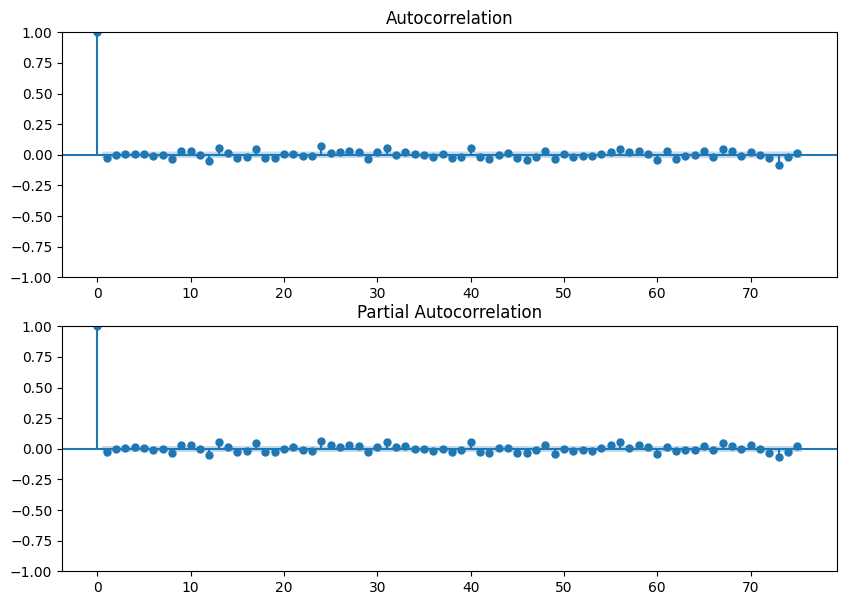

In [106]:
plot_acf_pacf(px)

#Check the values of PACF, Looks like difference in price is correlated with difference of price of period 13,14

In [113]:
pacf_values = pacf(px)

# Print PACF values
print("Partial Autocorrelation Function (PACF) values:")
for lag, pacf_val in enumerate(pacf_values):
    print(f"Lag {lag}: {pacf_val}")

Partial Autocorrelation Function (PACF) values:
Lag 0: 1.0
Lag 1: -0.029953695590273978
Lag 2: -0.0006419616424950073
Lag 3: 0.003914413640791362
Lag 4: 0.010658480488655636
Lag 5: 0.005336620018012284
Lag 6: -0.010977606047608411
Lag 7: -0.0033150368050462974
Lag 8: -0.03438193701014627
Lag 9: 0.02960384991636868
Lag 10: 0.03103941957309095
Lag 11: 0.0009701398311308965
Lag 12: -0.04937637413256422
Lag 13: 0.05286965297619981
Lag 14: 0.015737329235688446
Lag 15: -0.02330357048194451
Lag 16: -0.020974556082615302
Lag 17: 0.05044854029869338
Lag 18: -0.023314126977212416
Lag 19: -0.026077860001218544
Lag 20: 0.0007289125122135131
Lag 21: 0.015296083121736252
Lag 22: -0.009535360304880402
Lag 23: -0.014542825222301214
Lag 24: 0.06571203489805875
Lag 25: 0.03253922160042251
Lag 26: 0.014694201831164237
Lag 27: 0.029273443793206316
Lag 28: 0.025286178398501055
Lag 29: -0.02364396049821741
Lag 30: 0.010949020896538066
Lag 31: 0.05412090092899842
Lag 32: 0.015554601703727423
Lag 33: 0.019066

Install fitters library if needed.
<br>
#!pip install fitter

In [118]:
from fitter import Fitter, get_common_distributions

Based on AIC, it looks like Cauchy distribution is the best fit, followed by LogNormal

C:\Users\bpree\AppData\Local\Temp\ipykernel_17356\2658096587.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  f = Fitter(df_btc['PriceUSD'].pct_change().dropna(), distributions=get_common_distributions())


          sumsquare_error          aic          bic  kl_div  ks_statistic  \
cauchy           8.456708   429.153821   442.435826     inf      0.029961   
lognorm        260.896725  3596.647346  3616.570353     inf      0.128328   
norm           263.087028  3601.416363  3614.698368     inf      0.128935   
exponpow       685.316888  3176.791248  3196.714255     inf      0.343573   
rayleigh       856.809941    68.539607    81.821612     inf      0.478622   

             ks_pvalue  
cauchy    7.576113e-05  
lognorm   1.052510e-81  
norm      1.769834e-82  
exponpow  0.000000e+00  
rayleigh  0.000000e+00  
Best fitting distribution: uniform


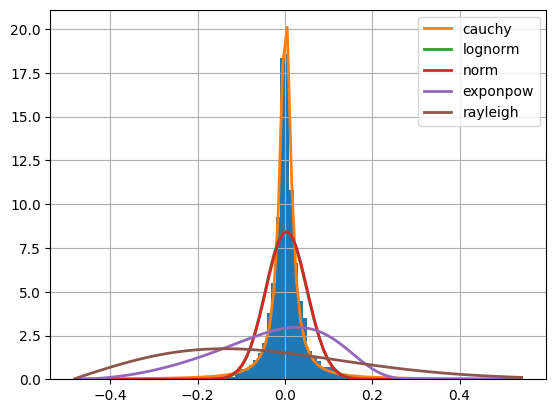

In [120]:
# Fit the data to common distributions
f = Fitter(df_btc['PriceUSD'].pct_change().dropna(), distributions=get_common_distributions())
f.fit()

# Print a summary of the best-fitting distributions
print(f.summary()) 

# You can also get the best fit distribution name and parameters
best_dist = f.get_best(method='aic') # 'aic', 'bic', or 'sumsquare_error'
print(f"Best fitting distribution: {list(best_dist.keys())[0]}")

In [125]:
df_btc.index


DatetimeIndex(['2009-01-03', '2009-01-04', '2009-01-05', '2009-01-06',
               '2009-01-07', '2009-01-08', '2009-01-09', '2009-01-10',
               '2009-01-11', '2009-01-12',
               ...
               '2026-01-05', '2026-01-06', '2026-01-07', '2026-01-08',
               '2026-01-09', '2026-01-10', '2026-01-11', '2026-01-12',
               '2026-01-13', '2026-01-14'],
              dtype='datetime64[ns]', name='time', length=6221, freq='D')

We find the same distribution applies to data for a given year.

In [131]:
#Check the same for a given year. 
df_btc_2025=df_btc[df_btc.index.year == 2025]
df_btc_2025.shape

(365, 31)

         sumsquare_error         aic         bic  kl_div  ks_statistic  \
cauchy        844.866424 -140.729189 -132.934881     inf      0.053277   
norm         1284.375181   18.710351   26.504658     inf      0.064815   
lognorm      1288.359162   13.764491   25.455953     inf      0.068469   
gamma        1296.753282   10.807883   22.499345     inf      0.071118   
chi2         1353.309819   -0.276458   11.415004     inf      0.080921   

         ks_pvalue  
cauchy    0.243989  
norm      0.089857  
lognorm   0.062853  
gamma     0.047917  
chi2      0.016050  
Best fitting distribution: uniform


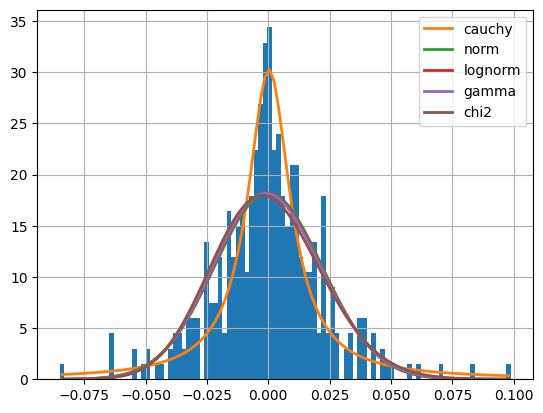

In [133]:
f = Fitter(df_btc_2025['PriceUSD'].pct_change().dropna(), distributions=get_common_distributions())
f.fit()

# Print a summary of the best-fitting distributions
print(f.summary()) 

# You can also get the best fit distribution name and parameters
best_dist = f.get_best(method='aic') # 'aic', 'bic', or 'sumsquare_error'
print(f"Best fitting distribution: {list(best_dist.keys())[0]}")

Check Variable Auto Regression for btc dataset. This will identify any correlation with other variables.

In [146]:
df_btc_2025.diff()

,AdrActCnt,AdrBalCnt,AssetCompletionTime,AssetEODCompletionTime,BlkCnt,CapMVRVCur,CapMrktCurUSD,CapMrktEstUSD,FeeTotNtv,FlowInExNtv,...,ReferenceRateETH,ReferenceRateEUR,ReferenceRateUSD,SplyCur,SplyExNtv,SplyExUSD,SplyExpFut10yr,TxCnt,TxTfrCnt,volume_reported_spot_usd_1d
time,,,,,,,,,,,,,,,,,,,,,
2025-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-02,144267.0,-21720.0,90547.0,90547.0,27.0,0.054844,4.749335e+10,4.748280e+10,1.029384,7419.364346,...,NaN,NaN,NaN,521.864372,950.305322,6.092753e+09,130.46875,121940.0,198173.0,9.219885e+09
2025-01-03,-31988.0,22271.0,81708.0,81708.0,-25.0,0.028406,2.518145e+10,2.518957e+10,0.400868,-7536.616101,...,NaN,NaN,NaN,443.725856,-1176.118339,3.065243e+09,110.93750,-12157.0,15222.0,-4.158850e+09
2025-01-04,-74509.0,36805.0,89401.0,89401.0,7.0,0.001225,2.211689e+09,2.209243e+09,-0.035040,-9272.633245,...,NaN,NaN,NaN,465.610024,-2044.438294,7.309310e+07,116.40625,38597.0,18553.0,-6.430485e+09
2025-01-05,-27000.0,1603.0,83944.0,83944.0,7.0,0.003450,3.707342e+09,3.705765e+09,-0.164397,787.303389,...,NaN,NaN,NaN,487.481411,-140.690651,4.485492e+08,121.87500,-5987.0,-59453.0,-1.130876e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-27,-44119.0,30734.0,85434.0,85434.0,-20.0,0.006331,7.237686e+09,7.243099e+09,-0.302339,-13088.831124,...,NaN,NaN,NaN,424.999992,-1699.937401,7.545019e+08,106.25000,-38346.0,-72897.0,-9.277042e+09
2025-12-28,3270.0,24326.0,86608.0,86608.0,19.0,0.001241,1.085488e+09,1.078335e+09,0.075623,412.130760,...,NaN,NaN,NaN,484.374984,2018.229003,3.078873e+08,121.09375,65688.0,127506.0,7.690826e+08
2025-12-29,120603.0,14577.0,88305.0,88305.0,-1.0,-0.010528,-1.222139e+10,-1.221878e+10,0.650736,22607.908606,...,NaN,NaN,NaN,481.249891,-1586.961407,-1.677325e+09,120.31250,7557.0,20121.0,1.183290e+10


In [152]:
tmp.columns

Index(['PriceUSD', 'TxCnt', 'TxTfrCnt', 'BlkCnt', 'PriceBTC', 'HashRate',
       'FlowInExUSD', 'FlowOutExUSD'],
      dtype='object')

In [176]:
#tmp = df_btc_2025[['PriceUSD','TxCnt','TxTfrCnt','BlkCnt','PriceBTC','HashRate','FlowInExUSD','FlowOutExUSD']]
tmp = df_btc_2025[['PriceUSD','TxCnt','TxTfrCnt','BlkCnt','HashRate','FlowInExUSD','FlowOutExUSD']]
tmp = tmp.diff().dropna()
model = VAR(tmp)
for i in range(1,20):

    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  179.90300069225802
BIC :  180.50379011021624
FPE :  1.3517680547194891e+78
HQIC:  180.14181160572812 

Lag Order = 2
AIC :  179.36634889411005
BIC :  180.49514072350703
FPE :  7.906056322264165e+77
HQIC:  179.815084732458 

Lag Order = 3
AIC :  179.32570228480924
BIC :  180.98466961329473
FPE :  7.596660184522868e+77
HQIC:  179.98527061684598 

Lag Order = 4
AIC :  179.20156161208004
BIC :  181.39289249648112
FPE :  6.71912845179385e+77
HQIC:  180.07287632197355 

Lag Order = 5
AIC :  179.06827570138515
BIC :  181.7941733111318
FPE :  5.894135721692324e+77
HQIC:  180.15225704883784 

Lag Order = 6
AIC :  179.00128890761613
BIC :  182.2639716699251
FPE :  5.531140431763064e+77
HQIC:  180.29886358876834 

Lag Order = 7
AIC :  178.99619704228215
BIC :  182.79789878912493
FPE :  5.529617433835366e+77
HQIC:  180.50829825135213 

Lag Order = 8
AIC :  179.15002867857132
BIC :  183.49299879545325
FPE :  6.491097490768516e+77
HQIC:  180.87759617024273 

Lag Order = 9
AIC : 

In [178]:
model_fitted = model.fit(6)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, Feb, 2026
Time:                     11:13:16
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    182.264
Nobs:                     358.000    HQIC:                   180.299
Log likelihood:          -35296.1    FPE:                5.53114e+77
AIC:                      179.001    Det(Omega_mle):     2.50026e+77
--------------------------------------------------------------------
Results for equation PriceUSD
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                 -26.239736       115.973149           -0.226           0.821
L1.PriceUSD            -0.043849         0.056014           -0.783           0.434
L1.TxCnt                0.001824         0.004735

#Check the durbin watson statistic
#Text copied from :https://medium.com/@ngaridennis3/developing-a-vector-autoregressive-model-in-python-698d064982c4

Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors). If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series. A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic. The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [182]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(tmp.columns, out):
    print((col), ':', round(val, 2))

PriceUSD : 2.0
TxCnt : 2.01
TxTfrCnt : 2.0
BlkCnt : 2.03
HashRate : 2.03
FlowInExUSD : 1.83
FlowOutExUSD : 1.88


We try to determine when there is a regime change.

In [ ]:
#Install ruptures library if need
#!pip install ruptures

[55, 110, 125, 190, 230, 275, 285, 305, 315, 320, 365]


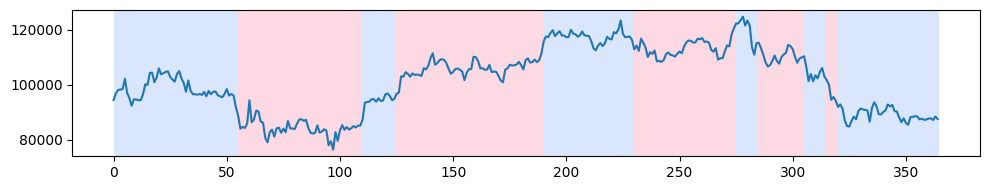

In [204]:
import ruptures as rpt
px=df_btc_2025['PriceUSD'].to_numpy()
algo = rpt.Dynp(model="l2").fit(px)
result = algo.predict(n_bkps=10)
print(result)
rpt.display(df_btc_2025['PriceUSD'],  result)
plt.show()

C:\ProgramData\anaconda3-2024\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


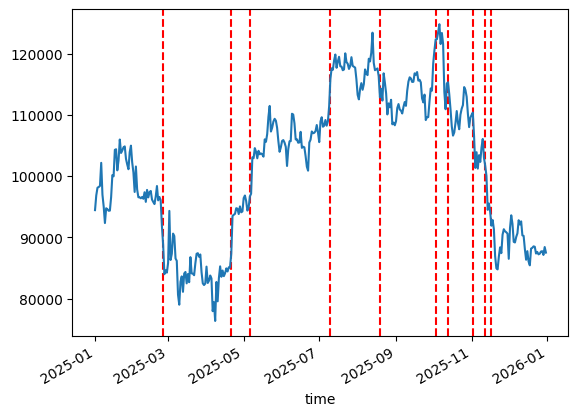

In [206]:
cnt=0
for r in result[:-1]:
    #plt.axvline(x=merged_df_2024.iloc[result[:-1]].index[0], color='red', linestyle='--', label='Vertical Line at 5')
    
    plt.axvline(x=df_btc_2025.iloc[result[:-1]].index[cnt], color='red', linestyle='--', label='Vertical Line at 5')
    cnt+=1
#tmp = _FEATURES_DF[_FEATURES_DF.index.year == 2023]
df_btc_2025['PriceUSD'].plot()

# Add labels and show the plot
#plt.legend()
plt.show()

In [220]:
df_btc_2025.iloc[result[:-1]].index

DatetimeIndex(['2025-02-25', '2025-04-21', '2025-05-06', '2025-07-10',
               '2025-08-19', '2025-10-03', '2025-10-13', '2025-11-02',
               '2025-11-12', '2025-11-17'],
              dtype='datetime64[ns]', name='time', freq=None)

TODO: Check if there are any significant data events from Market data.

Use the code provided in template to load features.

In [230]:
df_btc['PriceUSD_coinmetrics'] = df_btc['PriceUSD']
df_with_features = precompute_features(df_btc)

In [238]:
df_with_features.tail(5)

,PriceUSD_coinmetrics,price_ma,price_vs_ma,mvrv_zscore,mvrv_gradient,mvrv_acceleration,mvrv_zone,mvrv_volatility,signal_confidence,polymarket_sentiment
time,,,,,,,,,,
2026-01-10,90406.142411,106347.539014,-0.149266,-1.772495,0.484998,0.980591,-1.0,0.356546,0.747150,0.5
2026-01-11,90717.206315,106264.599720,-0.149899,-1.768737,0.493871,0.978523,-1.0,0.339833,0.747700,0.5
2026-01-12,91141.149849,106185.241355,-0.146308,-1.733451,0.520150,0.976070,-1.0,0.306407,0.749531,0.5
2026-01-13,95304.498294,106126.309051,-0.141678,-1.691778,0.546879,0.973329,-1.0,0.284123,0.751557,0.5
2026-01-14,0.000000,106120.121573,-0.101971,-1.404710,0.607226,0.970784,-1.0,0.281337,0.762778,0.5


Check if PriceUSD has any granger correlation with Sentiment.

In [241]:
ts_df = pd.DataFrame(columns=['price_vs_ma', 'polymarket_sentiment'], data=zip(df_with_features['price_vs_ma'],df_with_features['polymarket_sentiment']))
gc_res = grangercausalitytests(ts_df, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1716  , p=0.2791  , df_denom=5656, df_num=1
ssr based chi2 test:   chi2=1.1722  , p=0.2790  , df=1
likelihood ratio test: chi2=1.1721  , p=0.2790  , df=1
parameter F test:         F=1.1716  , p=0.2791  , df_denom=5656, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6753  , p=0.5090  , df_denom=5653, df_num=2
ssr based chi2 test:   chi2=1.3518  , p=0.5087  , df=2
likelihood ratio test: chi2=1.3516  , p=0.5087  , df=2
parameter F test:         F=0.6753  , p=0.5090  , df_denom=5653, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2194  , p=0.3009  , df_denom=5650, df_num=3
ssr based chi2 test:   chi2=3.6628  , p=0.3003  , df=3
likelihood ratio test: chi2=3.6616  , p=0.3004  , df=3
parameter F test:         F=1.2194  , p=0.3009  , df_denom=5650, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0841  , p=0.

polymarket_sentiment does not seem to cause price_vs_ma. 

In [246]:
ts_df = pd.DataFrame(columns=['PriceUSD_coinmetrics', 'polymarket_sentiment'], data=zip(df_with_features['PriceUSD_coinmetrics'],df_with_features['polymarket_sentiment']))
gc_res = grangercausalitytests(ts_df, 20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7099  , p=0.3995  , df_denom=5656, df_num=1
ssr based chi2 test:   chi2=0.7103  , p=0.3993  , df=1
likelihood ratio test: chi2=0.7103  , p=0.3994  , df=1
parameter F test:         F=0.7099  , p=0.3995  , df_denom=5656, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9640  , p=0.0190  , df_denom=5653, df_num=2
ssr based chi2 test:   chi2=7.9350  , p=0.0189  , df=2
likelihood ratio test: chi2=7.9295  , p=0.0190  , df=2
parameter F test:         F=3.9640  , p=0.0190  , df_denom=5653, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9428  , p=0.0317  , df_denom=5650, df_num=3
ssr based chi2 test:   chi2=8.8394  , p=0.0315  , df=3
likelihood ratio test: chi2=8.8325  , p=0.0316  , df=3
parameter F test:         F=2.9428  , p=0.0317  , df_denom=5650, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.6642  , p=0.

Based on p-values < 0.05 we can say that polymarket_sentiment has a causal affect on PriceUSD.